*UID*: 117987683


# **CMSC426 Project 2: Panorama Stitching**

# Introduction

The aim of this project is to implement an end-to-end pipeline for panorama stitching. We all use the panorama mode on our smart-phones– you’ll implement a pipeline which does the same basic thing!

This document just provides an overview of what you need to do. For a full breakdown of how each step in the pipeline works, see the [course notes](https://cmsc426.github.io/pano/) for this project.

# System Overview
Here’s a system diagram, showing each step in your panorama-stitching pipeline:
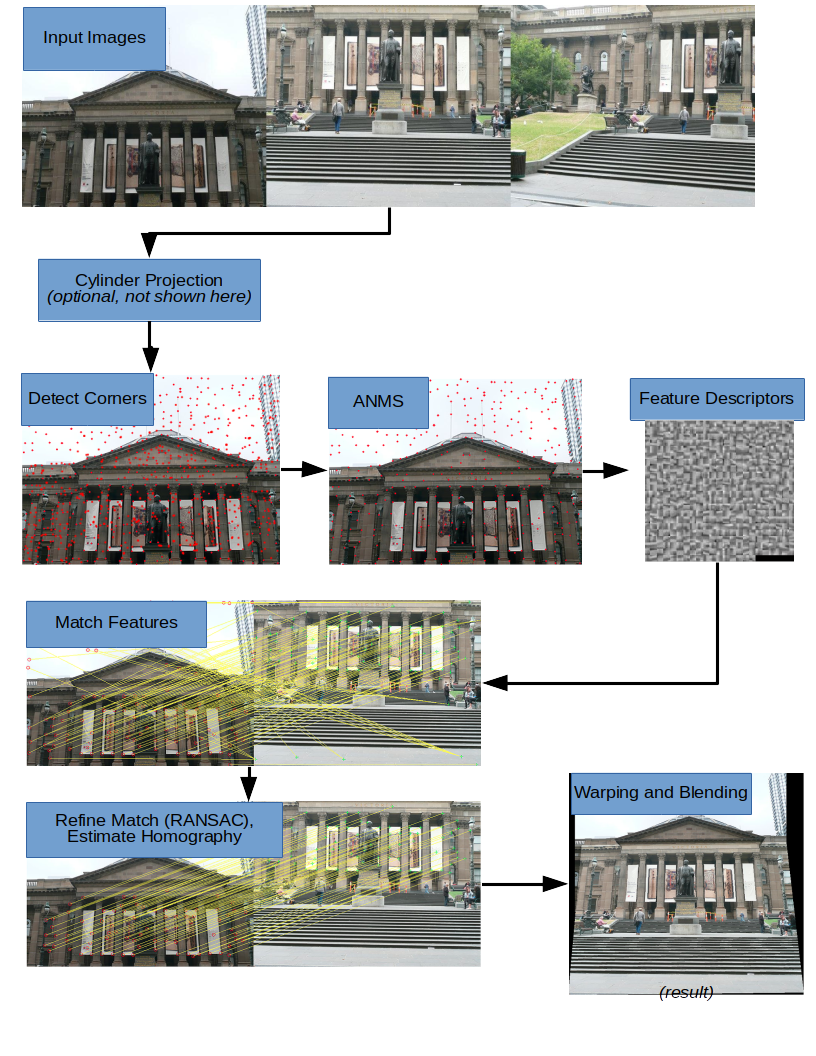







In [ ]:
# Download training images from Google Drive
import gdown
gdown.download_folder(id="1VAB_BG2gntlkwR059zR_8gd9pXajzgIk", quiet=True, use_cookies=False)

In [ ]:
# Check whether the training images were successfully imported
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from scipy import ndimage
import random

train_image = mpimg.imread('./train_images/Set1/1.jpg')
plt.imshow(train_image)
plt.axis("off")
plt.show()

## Problem Statement

### 1. Detect Corners and Adaptive Non-Maximal Suppression (or ANMS) [25 points]


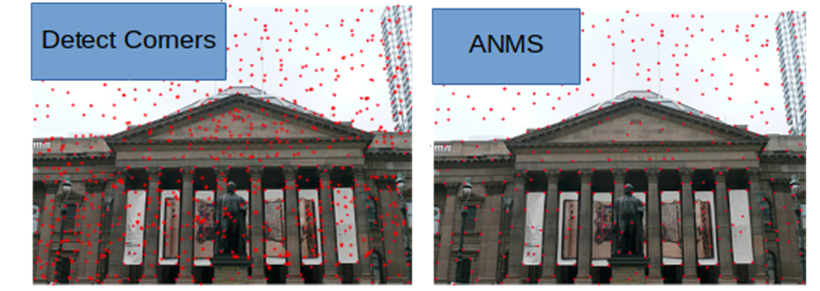

#### Step 1: Corner Detection

The first step in stitching a panorama is extracting corners like most computer vision tasks. Here we will use either Harris corners or Shi-Tomasi corners. Use **cv2.cornerHarris** or **cv2.goodFeaturesToTrack** to implement this part.


In [8]:
def detect_corner(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  corners = cv2.goodFeaturesToTrack(gray, 5000, 0.01, 10)
  cmap = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
  for i in corners:
      x, y = map(int, i.ravel())
      cmap[y, x] = gray[y, x]
  return cmap

In [ ]:
for i in range(1,4):
  for files in os.listdir(f'./train_images/Set{i}'):
    img = cv2.imread(f'./train_images/Set{i}/{files}')
    cmap = detect_corner(img)
    for y in range(cmap.shape[0]):
      for x in range(cmap.shape[1]):
        if cmap[y, x] > 0:
          cv2.circle(img, (x, y), 2, (0, 0, 255), -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

#### Step 2: Adaptive Non-Maximal Suppression (or ANMS)

The objective of this step is to detect corners such that they are equally distributed across the image in order to avoid weird artifacts in warping.

In a real image, a corner is never perfectly sharp, each corner might get a lot of hits out of the **N**
 strong corners - we want to choose only the **$N_{best}$**
 best corners after ANMS. In essence, you will get a lot more corners than you should! ANMS will try to find corners which are true local maxima. The algorithm for implementing ANMS is given below.



In [10]:
def ANMS(cmap, num_best):
   local_max = ndimage.maximum_filter(cmap, size=10)
   max = (cmap == local_max) & (cmap > 0)
   x, y = np.where(max)

   r = np.inf * np.ones(len(x))

   for i in range(len(x)):
         for j in range(len(x)):
            if cmap[x[j],y[j]] > cmap[x[i],y[i]]:
                  euclidean_dist = np.sqrt((x[j]-x[i])**2 + (y[j]-y[i])**2)
                  if euclidean_dist < r[i]:
                     r[i] = euclidean_dist

   sorted_corners = np.argsort(r)[::-1]
   return [(x[i], y[i]) for i in sorted_corners[:num_best]]

In [ ]:
for k in range(1,4):
  for files in os.listdir(f'./train_images/Set{k}'):
    img = cv2.imread(f'./train_images/Set{k}/{files}')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = detect_corner(img)
    sorted_corners = ANMS(corners, 100)
    for x, y in sorted_corners:
        cv2.circle(img, (y, x), 3, 255, -1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

### 2. Feature Descriptors: [15pts]

In the previous step, you found the feature points (locations of the Nbest
 best corners after ANMS are called the feature point locations). You need to describe each feature point by a feature vector, this is like encoding the information at each feature point by a vector. One of the easiest feature descriptor is described next.

Take a patch of **size 40×40**
 centered **(this is very important**) around the keypoint/feature point. Now apply gaussian blur (feel free to play around with the parameters, for a start you can use OpenCV’s default parameters in **cv2.GaussianBlur** command. Now, sub-sample the blurred output (this reduces the dimension) to 8×8
. Then reshape to obtain a 64×1
 vector. Standardize the vector to have zero mean and variance of 1. Standardization is used to remove bias and to achieve some amount of illumination invariance.

In [12]:
### Generate feature Descriptor for corners

def feature_descript(gray_img, corners):
  feature_descriptors = []

  for corner in corners:
    x, y = corner[0], corner[1]

    if(x - 20 >= 0 and y - 20 >= 0 and x + 20 < gray_img.shape[0] and y + 20 < gray_img.shape[1]):
      patch = gray_img[x - 20:x + 20, y - 20:y + 20]

      blurred_patch = cv2.GaussianBlur(patch, (5, 5), 0)
      blurred_patch = cv2.resize(patch, (8, 8))

      current_feature = blurred_patch.reshape(64, 1)

      mean = np.mean(current_feature)
      std_dev = np.std(current_feature)
      if(std_dev == 0): # check for division by 0
        current_feature = (current_feature - mean)
      else:
        current_feature = (current_feature - mean) / std_dev

      feature_descriptors.append(current_feature)

  #for i in np.array(feature_descriptors):
  #  print(i)

  resized_vector = np.array(feature_descriptors)

  return np.array(feature_descriptors)

In [ ]:
# Show you result here

### 3. Feature Matching: [15pts]

In the previous step, you encoded each keypoint by **64×1**
 feature vector. Now, you want to match the feature points among the two images you want to stitch together. In computer vision terms, this step is called as finding feature correspondences between the 2 images. Pick a point in image 1, compute sum of square differences between all points in image 2. Take the ratio of best match (lowest distance) to the second best match (second lowest distance) and if this is below some ratio keep the matched pair or reject it. Repeat this for all points in image 1. You will be left with only the confident feature correspondences and these points will be used to estimate the transformation between the 2 images, also called as Homography. Use the function **cv2.drawMatches** to visualize feature correspondences. Below is an image showing matched features.



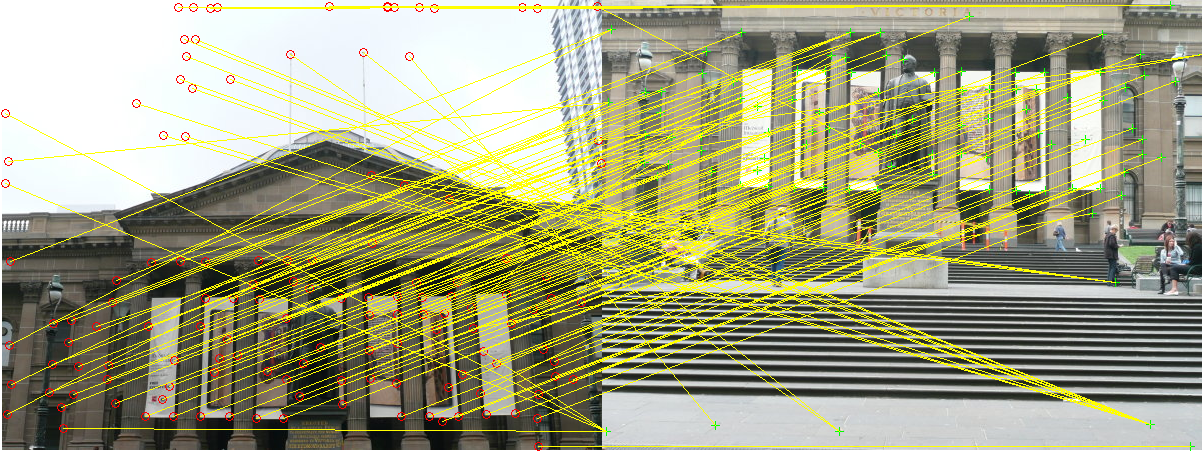

In [19]:
def feature_match(img1, img2, corner1, corner2):
    threshold = 0.8
    desc1 = feature_descript(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), corner1)
    desc2 = feature_descript(cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), corner2)
    
    matches = []
    for i, desc in enumerate(desc1):
        distances = (np.sum((desc2 - desc) ** 2, axis=1)).flatten()
        sorted_idx = np.argsort(distances)
        calc_ratio = distances[sorted_idx[0]] / distances[sorted_idx[1]]
        if(calc_ratio < threshold):
            matches.append(cv2.DMatch(i, sorted_idx[0], distances[sorted_idx[0]]))
    
    matches.sort(key=lambda x: x.distance)
    print(len(matches))


    # SWAP COORDS
    keypoints1 = [cv2.KeyPoint(float(y), float(x), 1) for x, y in corner1]  
    keypoints2 = [cv2.KeyPoint(float(y), float(x), 1) for x, y in corner2]  

    img_matches = cv2.drawMatches(img1, keypoints1,
                                  img2, keypoints2,
                                  matches[:100], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    return matches, img_matches, keypoints1, keypoints2

In [ ]:
# Show you result here
# for k in range(1): #1,4
#   for files in os.listdir(f'./train_images/Set{k}'):
#     img = cv2.imread(f'./train_images/Set{k}/{files}')
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     corners = detect_corner(img)
#     sorted_corners = ANMS(corners, 100)
#     for x, y in sorted_corners:
#         cv2.circle(img, (y, x), 3, 255, -1)

#     feature_match()
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#     plt.axis("off")
#     plt.show()

for k in range(1,4):  # 1,4
    image_files = sorted(os.listdir(f'./train_images/Set{k}'))    
    
    for i in range(len(image_files) - 1): 
        img1 = cv2.imread(f'./train_images/Set{k}/{image_files[i]}')
        img2 = cv2.imread(f'./train_images/Set{k}/{image_files[i+1]}')
        
        corners1 = detect_corner(img1)
        corners2 = detect_corner(img2)
        
        sorted_corners1 = ANMS(corners1, 100)
        sorted_corners2 = ANMS(corners2, 100)
        
        for x, y in sorted_corners1:
            cv2.circle(img1, (y, x), 3, (0, 255, 0), -1)
        for x, y in sorted_corners2:
            cv2.circle(img2, (y, x), 3, (0, 255, 0), -1)
        
        matches, img_matches = feature_match(img1, img2, sorted_corners1, sorted_corners2)
        print(matches[0].queryIdx)
        print(matches[0].trainIdx)
        
        plt.figure(figsize=(20, 10))
        plt.subplot(133), plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)), plt.title('Feature Matches'), plt.axis('off')
        plt.tight_layout()
        plt.show()



### 4. RANSAC for outlier rejection and to estimate Robust Homography: [20pts]


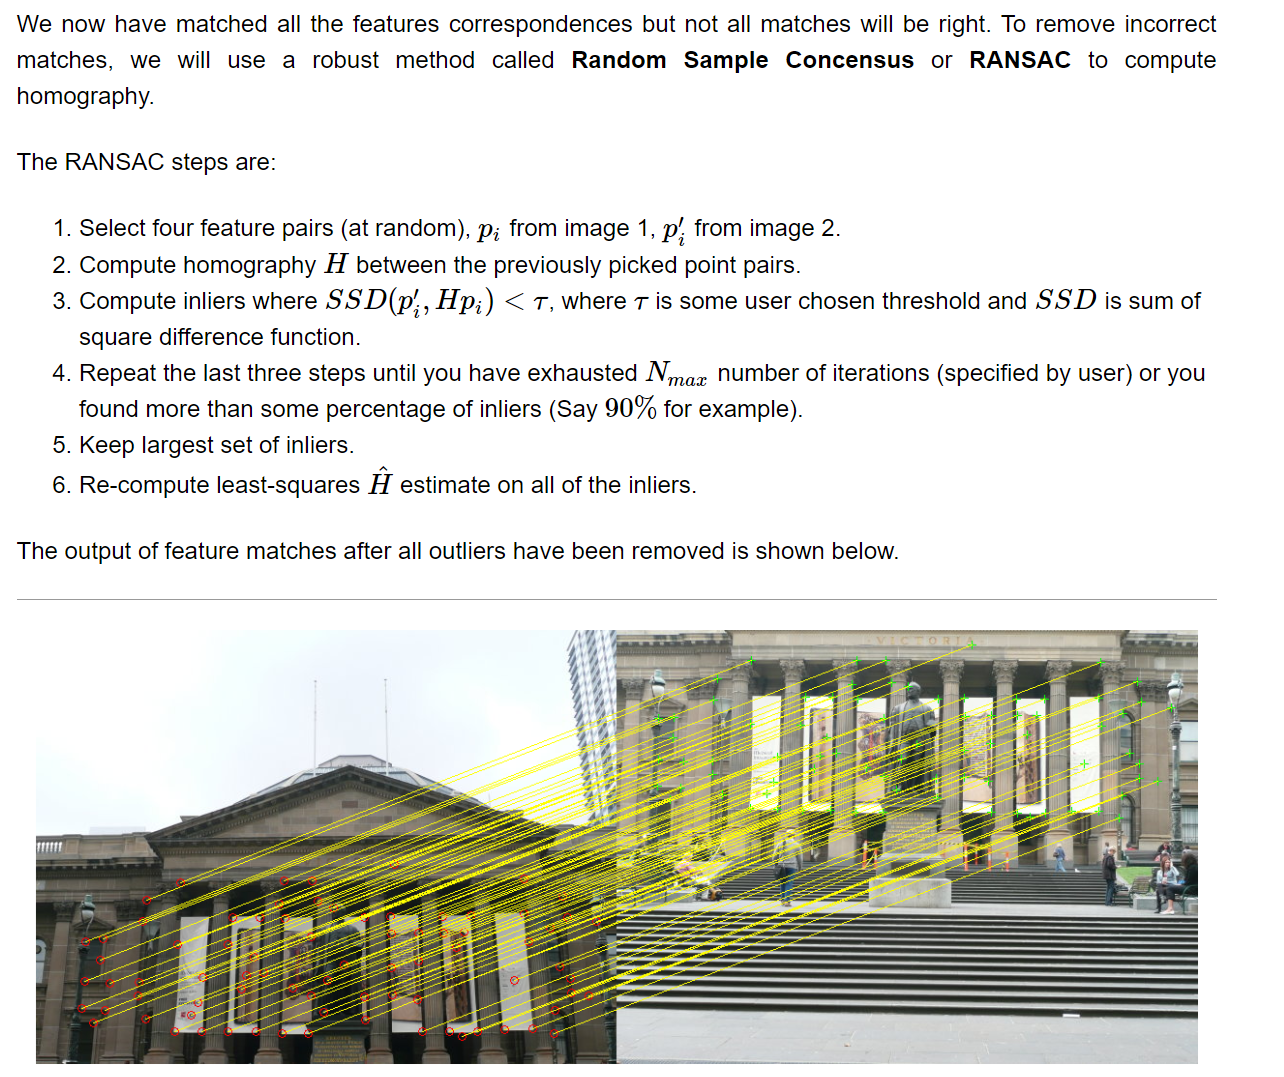

In [23]:
# Ransac to filter out the wrong matchings and return homography
def RANSAC(match_kp1, match_kp2, N, t, threshold):
  inliers = []
  homography = None
  max_inliers = []

  for _ in range(N):
    rand = random.sample(range(len(match_kp1)), 4)
    pt1 = np.array([match_kp1[i] for i in rand])
    pt2 = np.array([match_kp2[i] for i in rand])

    homo = cv2.getPerspectiveTransform(pt1, pt2)

    current_inliers = []
    for i in range(len(match_kp1)):
      pta = np.append(match_kp1[i], 1)
      ptb = np.append(match_kp2[i], 1)
      
      projected_a = np.dot(homo, pta)
      projected_a /= projected_a[2] 

      ssd = np.sum((projected_a[:2] - ptb[:2]) ** 2) #homography sq diff

      if ssd < t:
        current_inliers.append(i)

      if len(inliers) > len(max_inliers):
            max_inliers = inliers
            homography = homo

      if len(max_inliers) > threshold * len(match_kp1):
            break
      
  # pt1 = np.array([match_kp1[i] for i in inliers])
  # pt2 = np.array([match_kp2[i] for i in inliers])

  # real_homo = cv2.getPerspectiveTransform(pt1, pt2)

  return homography

In [25]:
for k in range(1,4):  # 1,4
    image_files = sorted(os.listdir(f'./train_images/Set{k}'))    
    
    for i in range(len(image_files) - 1): 
        img1 = cv2.imread(f'./train_images/Set{k}/{image_files[i]}')
        img2 = cv2.imread(f'./train_images/Set{k}/{image_files[i+1]}')
        
        corners1 = detect_corner(img1)
        corners2 = detect_corner(img2)
        
        sorted_corners1 = ANMS(corners1, 100)
        sorted_corners2 = ANMS(corners2, 100)

        matches, img_matches, keypoints1, keypoints2 = feature_match(img1, img2, sorted_corners1, sorted_corners2)

        match_kp1 = []
        match_kp2 = []
    
        for match in matches:
            kp1 = keypoints1[match.queryIdx]
            kp2 = keypoints2[match.trainIdx]
            match_kp1.append(np.float32([kp1.pt[0], kp1.pt[1]]))
            match_kp2.append(np.float32([kp2.pt[0], kp2.pt[1]]))

        # query_points = np.array([corners1[match.queryIdx] for match in matches])
        # train_points = np.array([corners2[match.trainIdx] for match in matches])
        
        RANSAC(match_kp1, match_kp2, 100, 0.7, 50)

38
[array([288.,  54.], dtype=float32), array([ 47., 392.], dtype=float32), array([412., 166.], dtype=float32), array([526., 369.], dtype=float32), array([485., 441.], dtype=float32), array([ 28., 447.], dtype=float32), array([563., 322.], dtype=float32), array([512., 413.], dtype=float32), array([565., 146.], dtype=float32), array([282., 418.], dtype=float32), array([284., 379.], dtype=float32), array([481., 350.], dtype=float32), array([426., 416.], dtype=float32), array([ 31., 327.], dtype=float32), array([583.,  11.], dtype=float32), array([368., 416.], dtype=float32), array([591., 448.], dtype=float32), array([231., 298.], dtype=float32), array([168., 360.], dtype=float32), array([586., 345.], dtype=float32), array([405., 254.], dtype=float32), array([530., 203.], dtype=float32), array([460., 253.], dtype=float32), array([423., 341.], dtype=float32), array([  8., 261.], dtype=float32), array([361.,  52.], dtype=float32), array([106., 326.], dtype=float32), array([227., 416.], dtyp

/var/folders/t4/whgx7y7x6nj0p58dc2r8wb1r0000gn/T/ipykernel_63218/1679921805.py:20: RuntimeWarning: divide by zero encountered in divide
  projected_a /= projected_a[2]
/var/folders/t4/whgx7y7x6nj0p58dc2r8wb1r0000gn/T/ipykernel_63218/1679921805.py:20: RuntimeWarning: invalid value encountered in divide
  projected_a /= projected_a[2]


29
[array([574., 292.], dtype=float32), array([  3., 431.], dtype=float32), array([116., 241.], dtype=float32), array([468., 302.], dtype=float32), array([497., 188.], dtype=float32), array([473., 250.], dtype=float32), array([576., 121.], dtype=float32), array([594., 378.], dtype=float32), array([248.,  72.], dtype=float32), array([585., 229.], dtype=float32), array([461., 399.], dtype=float32), array([ 17., 348.], dtype=float32), array([312.,  72.], dtype=float32), array([141., 142.], dtype=float32), array([ 24., 232.], dtype=float32), array([360., 399.], dtype=float32), array([ 42., 162.], dtype=float32), array([ 94., 263.], dtype=float32), array([530.,   3.], dtype=float32), array([37., 59.], dtype=float32), array([307., 286.], dtype=float32), array([111.,   3.], dtype=float32), array([519., 102.], dtype=float32), array([401., 307.], dtype=float32), array([204., 236.], dtype=float32), array([262., 398.], dtype=float32), array([ 44., 448.], dtype=float32), array([397., 249.], dtype=

KeyboardInterrupt: 

### 5. Image Warping (and Blending): [25pts]

Panorama can be produced by overlaying the pairwise aligned images to create the final output image. The output panorama stitched from two images shown in the figure below.

When blending these images, there are inconsistency between pixels from different input images due to different exposure/white balance settings or photometric distortions or vignetting. This can be resolved by [Poisson blending](http://www.irisa.fr/vista/Papers/2003_siggraph_perez.pdf). You can use third party code only for the seamless panorama stitching.

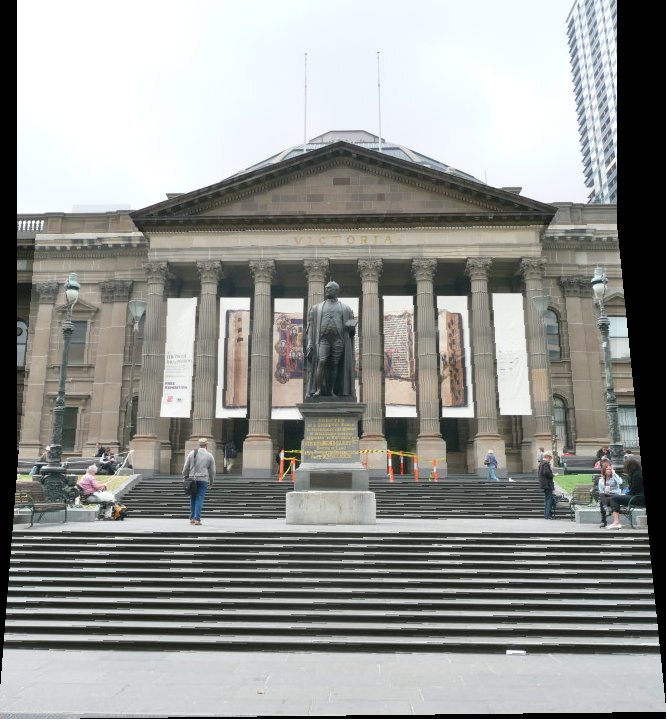

In [ ]:
# Warp and Blend two images together based on Homography returned in RANSAC
def warp_and_blend(img1, img2, H):
  return None

In [ ]:
# Show you result here

### 6. Putting Everything Together (Stitching more than 2 images)

In [ ]:
# Take in a list of images and stitch them together!
def pano_imgs(img_list):
  return None

In [ ]:
# Show you result here

## Report
You will be graded primarily based on your report.
A demonstration of understanding of the concepts involved in the project are required show the output produced by your code.

Include visualizations of the output of each stage in your pipeline (as shown in the system diagram on page 2), and a description of what you did for each step. Assume that we’re familiar with the project, so you don’t need to spend time repeating what’s already in the course notes. Instead, focus on any interesting problems you encountered and/or solutions you implemented.

Be sure to include the output panoramas for **all three image sets (from the trainingsets)**. Because you have limited time in which to access the “test set” images, we won’t expect in-depth analysis of your results for them.

As usual, your report must be full English sentences, **not** commented code. There is a word limit of 1500 words and no minimum length requirement.

 **TEST SET will be available 4 days before deadline: TBD on Piazza**

## ***add your report here***


# Allowed Functions

For cv2 advanced functions, only these are allowed:
1. For feature detection: **cv2.cornerHarris**, **cv2.cornerHarris**
2. For drawing matches: **cv2.drawMatches**
3. For estimate homograhy and warping: **cv2.getPerspectiveTransform**, **cv2.warpPerspective**

# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj2.pdf**. For example, xyz123_proj2.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.